In [1]:
import os
from os.path import join

import sys
import numpy as np
import glob

import pathlib
from pathlib import Path

from PIL import Image
from itertools import islice

from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Subset

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
mnist_dataset = torchvision.datasets.MNIST('./', 'train', download=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.55MB/s]


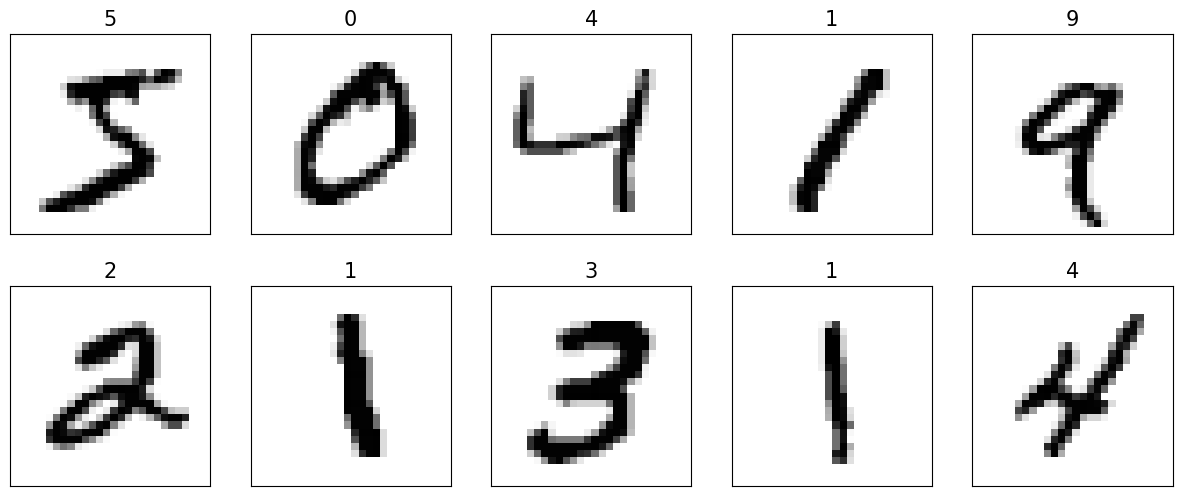

In [3]:

fig = plt.figure(figsize=(15, 6))
for i, (image, label) in islice(enumerate(mnist_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}', size=15)

plt.show()

In [ ]:
# NeuralNet case

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=transform, download=False)
mnist_test_dataset = torchvision.datasets.MNIST(root='./', train=False, transform=transform, download=False)
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

In [ ]:
hidden_units = [32, 16]
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]
all_layers = [nn.Flatten()]
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 10))
all_layers.append(nn.Softmax(dim=1))

model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
  (6): Softmax(dim=1)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.manual_seed(1)
num_epochs = 20
for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()

    accuracy_hist_train /= len(train_dl.dataset)
    print(f'Epoch {epoch} Accuracy {accuracy_hist_train}')

Epoch 0 Accuracy 0.7754166722297668
Epoch 1 Accuracy 0.9151666760444641
Epoch 2 Accuracy 0.9298999905586243
Epoch 3 Accuracy 0.9384166598320007
Epoch 4 Accuracy 0.9433000087738037
Epoch 5 Accuracy 0.9469833374023438
Epoch 6 Accuracy 0.9508000016212463
Epoch 7 Accuracy 0.9538999795913696
Epoch 8 Accuracy 0.9561166763305664
Epoch 9 Accuracy 0.9581000208854675
Epoch 10 Accuracy 0.9597833156585693
Epoch 11 Accuracy 0.9607333540916443
Epoch 12 Accuracy 0.9629999995231628
Epoch 13 Accuracy 0.9643833041191101
Epoch 14 Accuracy 0.9653666615486145
Epoch 15 Accuracy 0.9671499729156494
Epoch 16 Accuracy 0.9679333567619324
Epoch 17 Accuracy 0.968999981880188
Epoch 18 Accuracy 0.9701333045959473
Epoch 19 Accuracy 0.9701166749000549


In [ ]:
pred = model(mnist_test_dataset.data / 255.0)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
is_correct.mean()

tensor(0.9574)

In [1]:
# Deep Convolutional NeuralNet case

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=transform, download=False)
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root='./', train=False, transform=transform, download=False)

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [5]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [6]:
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [7]:
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [8]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))
model.add_module('softmax', nn.Softmax(dim=1))

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch + 1} accuracy: {accuracy_hist_train[epoch]} val_accuracy: {accuracy_hist_valid[epoch]}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [11]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.910260021686554 val_accuracy: 0.9682000279426575
Epoch 2 accuracy: 0.9729999899864197 val_accuracy: 0.9800000190734863
Epoch 3 accuracy: 0.9801200032234192 val_accuracy: 0.9757000207901001
Epoch 4 accuracy: 0.982479989528656 val_accuracy: 0.9829999804496765
Epoch 5 accuracy: 0.9847400188446045 val_accuracy: 0.9848999977111816
Epoch 6 accuracy: 0.9848600029945374 val_accuracy: 0.9872000217437744
Epoch 7 accuracy: 0.9861400127410889 val_accuracy: 0.98580002784729
Epoch 8 accuracy: 0.9876400232315063 val_accuracy: 0.9824000000953674
Epoch 9 accuracy: 0.9874399900436401 val_accuracy: 0.9861000180244446
Epoch 10 accuracy: 0.9882000088691711 val_accuracy: 0.9883000254631042
Epoch 11 accuracy: 0.9889199733734131 val_accuracy: 0.9858999848365784
Epoch 12 accuracy: 0.9889199733734131 val_accuracy: 0.9858999848365784
Epoch 13 accuracy: 0.9889000058174133 val_accuracy: 0.9850999712944031
Epoch 14 accuracy: 0.9884600043296814 val_accuracy: 0.984499990940094
Epoch 15 accuracy: 0

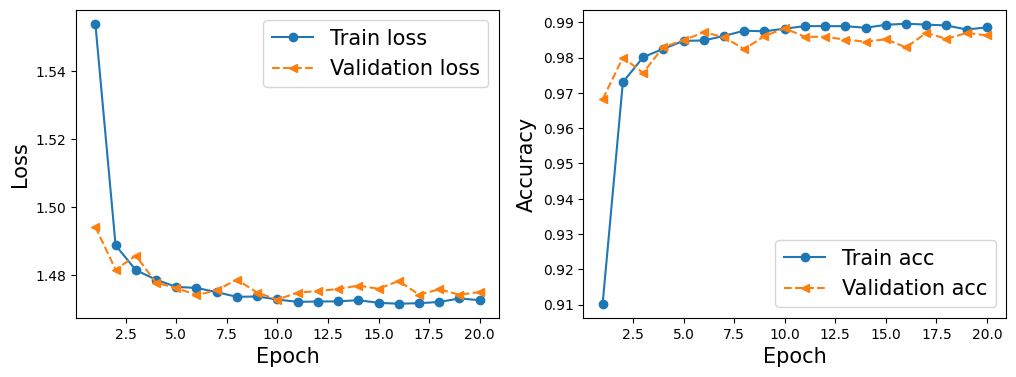

In [13]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc')
ax.plot(x_arr, hist[3], '--<', label='Validation acc')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [14]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.0)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
is_correct.mean()

tensor(0.9905)

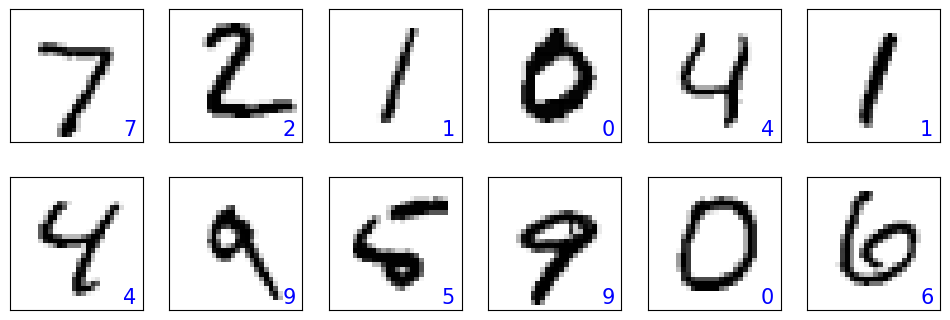

In [16]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), size=15, color='blue', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()